# Crash Analysis - HIC Example


At "Arbeitskreises Messdatenverarbeitung Fahrzeugsicherheit" ([MDVFS](http://mdvfs.org)) you can find the "Description of Injury Criteria for Vehicle Safety Tests" for [free download](http://mdvfs.org/download/crash-analysis-criteria-2-4-3/) which contains the definition of the calculation of all injury criterias including the "Head Injury Criterion" or short HIC.

And in this Notebook we'll show you, how you can get the needed channel data from an ASAM ODS server and do the calculation.

Please note: Even though we've studied the specification document and did the implementation seriously, we cannot guarantee the calculated HIC value to be correct.



## Dependencies for this notebook

💡The [ASAM ODSBox](https://pypi.org/project/odsbox/) contains some functionality that wraps the ODS HTTP API making using Python easier 😊
And for sure you need numpy to do the calculation work...

In [12]:
try:
  import odsbox
except ImportError:
  %pip install odsbox


import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

from odsbox.con_i import ConI
from odsbox.submatrix_to_pandas import submatrix_to_pandas


## Head Injury Criterion or short HIC

The formula for HIC is:

$$
\text{HIC} = \left( t_2 - t_1 \right) \left( \frac{1}{t_2 - t_1} \int_{t_1}^{t_2} a_{\text{res}}(t) \, dt \right)^{2.5}
$$

with the resultant acceleration a_res of the center of gravity of the head in units of acceleration of gravity (1 g = 9.81 m/s²). t1 and t2 mark the lower and upper limit of the time range during an impact in which the HIC value is maximum. Measured times are to be given in seconds.

The formula for the resultant acceleration is:

$$
\mathbf{a}_{\text{res}} = \sqrt{a_x^2 + a_y^2 + a_z^2}
$$

Where:
- \( a_x \) is the acceleration in the \( x \)-direction.
- \( a_y \) is the acceleration in the \( y \)-direction.
- \( a_z \) is the acceleration in the \( z \)-direction.

The measured channels of the head acceleration (a_x , a_y , a_z ) are filtered in accordance with CFC 1000.

### Establish session

The ODS HTTP API is a session based API. The session ID is called con_i in the ODS documentation. The [ASAM ODSBox](https://pypi.org/project/odsbox/) uses con_i as API object representing the session. Close this session to release the connection license. Otherwise the session will be auto closed after 30 minutes of inactivity.

Please note: We're using an internal ASAM ODS server to gather the data. You'll have to adapt the connection parameters to make it work for you. 

In [13]:

con_i = ConI(url='http://localhost:8087/api', auth=('sa','sa'))


### Load Data

The data we're looking for are the  measured channels of the head acceleration (a_x , a_y , a_z )

The ISO TS 13499 code describes the input channels for the HIC as follows:

```
? ? HEAD 00 00 ?? AC X A :Head Acceleration X, CFC 1000
? ? HEAD 00 00 ?? AC Y A :Head Acceleration Y, CFC 1000
? ? HEAD 00 00 ?? AC Z A :Head Acceleration Z, CFC 1000
? ? HEAD 00 00 ?? AC X B :Head Acceleration X, CFC 600, (UN-R80)
? ? HEAD 00 00 ?? AC Y B :Head Acceleration Y, CFC 600, (UN-R80)
? ? HEAD 00 00 ?? AC Z B :Head Acceleration Z, CFC 600, (UN-R80)
```

So we're loading a crash test data set and extract the channels we need:

In [14]:

sms = con_i.query_data({
    "SubMatrix": {"Name": {"$like": "CHANNEL_3500Values_1"}},
    "$attributes": {
        "Name": 1,
        "Id": 1
    },
    "$options": {"$rowlimit": 100}
})

submatrix_id = sms["SubMatrix.Id"].iloc[0]

# We need the data as a pandas DataFrame
df = submatrix_to_pandas(con_i, submatrix_id)

# The time channel is the index of the DataFrame
df.set_index("00TIRS000001TI00", inplace=True)

# Extract the head acceleration channels
a_x = df["24HEADCG0000ACXP"];
a_y = df["24HEADCG0000ACYP"];
a_z = df["24HEADCG0000ACZP"];


In [15]:
accel = df[["24HEADCG0000ACXP", "24HEADCG0000ACYP", "24HEADCG0000ACZP"]]
accel

,24HEADCG0000ACXP,24HEADCG0000ACYP,24HEADCG0000ACZP
00TIRS000001TI00,,,
-0.0500,-0.048988,-0.814257,0.656673
-0.0499,-1.209219,-1.750183,0.656673
-0.0498,-1.595964,1.993525,-1.005790
-0.0497,-1.209219,-0.346293,0.241057
-0.0496,-0.048988,0.589634,1.072289
...,...,...,...
0.2995,25.476208,-27.488138,38.893272
0.2996,25.862883,-27.956112,38.477665
0.2997,26.249655,-28.424084,36.815243


### Plot the acceleration channels 

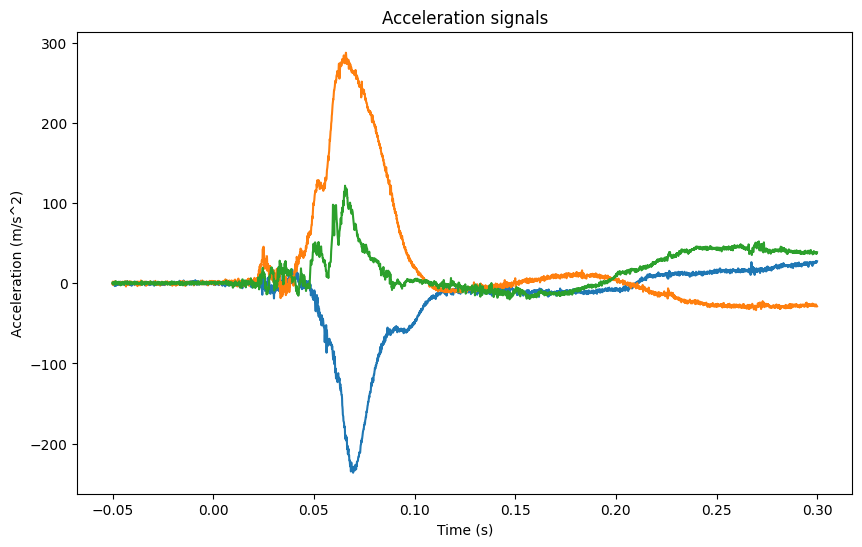

In [16]:

plt.figure(figsize=(10, 6))
plt.plot(a_x)
plt.plot(a_y)
plt.plot(a_z)

plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Acceleration signals')

plt.show()


### Some library functions we need

#### CFC Filter
The measured channels of the head acceleration (ax , ay , az ) are filtered in accordance with CFC 1000 (c.f. CFC Filters).

In [17]:
def cfc_1000_filter(data, cutoff_frequency=1000, sampling_rate=10000):
    filter_order = 4
    
    # Normalize the cutoff frequency with respect to the Nyquist frequency
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    
    # Design the Butterworth filter
    b, a = signal.butter(filter_order, normalized_cutoff, btype='low', analog=False)
    
    # Apply the filter to the data
    filtered_data = signal.filtfilt(b, a, data)
       
    return filtered_data

Let's apply the filter for our signals

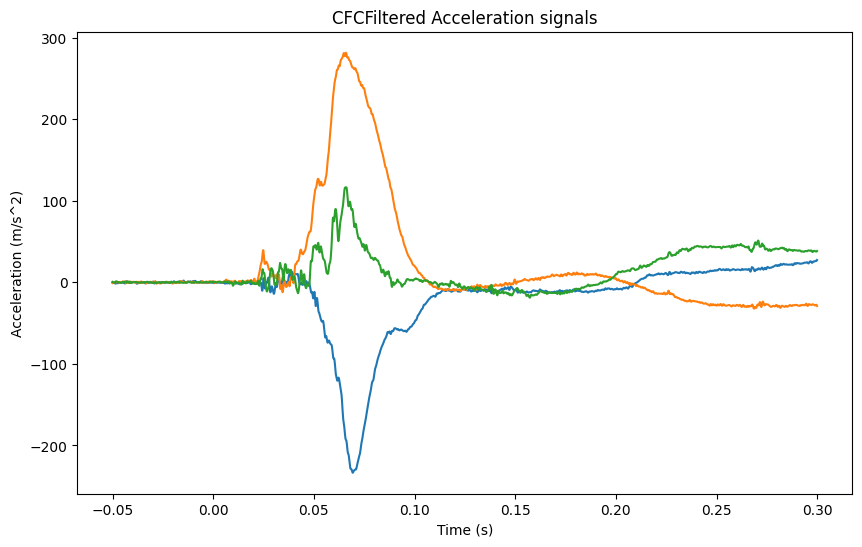

In [18]:
a_x = cfc_1000_filter(a_x)
a_y = cfc_1000_filter(a_y)
a_z = cfc_1000_filter(a_z)

time_array = np.array(df.index)

plt.figure(figsize=(10, 6))
plt.plot(time_array, a_x)
plt.plot(time_array, a_y)
plt.plot(time_array, a_z)

plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('CFCFiltered Acceleration signals')

plt.show()

#### Resultant Acceleration

We need the resultant acceleration of the center of gravity of the head in units of acceleration of gravity (1 g = 9.81 m/s²)

In [19]:
g = 9.81 # m/s^2

def calculate_resultant_in_g(c1, c2, c3):
    if c1 is None or c2 is None or c3 is None:
        return None

    # Calculate resultant acceleration
    resultant_in_g = ((c1 ** 2 + c2 ** 2 + c3 ** 2) ** (1 / 2)) / g

    return resultant_in_g

Let's calculate and plot the resultant acceleration

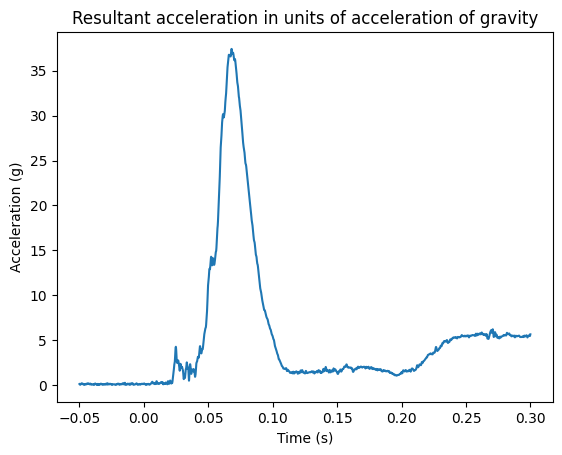

In [20]:

a_res = calculate_resultant_in_g(a_x, a_y, a_z)

plt.plot(time_array, a_res)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Resultant acceleration in units of acceleration of gravity')
plt.show()


#### HIC calculation

Now that we have calculated the needed input variables, we calculate the actual HIC value as the maximum of the integral of the resultant acceleration for a given time span (typical 15 or 36 ms)

In [31]:

#from scipy import integrate
from scipy.stats import trapezoid


def calculate_hic(acc, time_array, max_delta_t):

    assert 0 < max_delta_t < 100

    if acc is None:
        return None

    max_delta_t *= 1e-3 # detal_t is in ms, we need it in s

    res = 0
    res_t1 = None
    res_t2 = None

    # Now calculate the moving integral with the maximum being the HIC
    for idx_1, t1 in enumerate(time_array[:-1]):
        upper_limit_idx = (t1 + max_delta_t <= time_array).argmax()
        idx_2 = upper_limit_idx - 1
        t2 = time_array[idx_2]
        #a_int = np.trapz(acc_g_array[idx_1:idx_2+1], time_array[idx_1:idx_2+1])
        #a_int = integrate.simpson(get_data(acc, time_array[idx_1:idx_2+1]), time_array[idx_1:idx_2+1])
        data = np.interp(time_array[idx_1:idx_2+1], time_array, acc, left=0, right=0)
        a_int = np.trapz(data, time_array[idx_1:idx_2+1])
        
        # a_int = np.trapz(get_data(acc, time_array, time_array[idx_1:idx_2+1]), time_array[idx_1:idx_2+1])
        
        new_res = (t2 - t1) * (1 / (t2 - t1) * a_int) ** 2.5
        if new_res > res:
            res = new_res
            res_t1 = t1
            res_t2 = t2

    return res;

In [39]:
time_channel = np.array(df.index)
HIC36 = 36 #ms
HIC15 = 15 #ms

HIC = calculate_hic(a_res, time_channel, HIC15);



C:\Users\sro\AppData\Local\Temp\ipykernel_24076\808967285.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  a_int = np.trapz(data, time_array[idx_1:idx_2+1])


A HIC15 (meaning a measure of impact over 15 milliseconds) of 700 is estimated to represent a 5 percent risk of a severe injury (Mertz et al., 1997). A "severe" injury is one with a score of 4+ on the Abbreviated Injury Scale (AIS)

A comprehensive searchable database of vehicles and their HIC scores is available at [safercar.gov](https://www.safercar.gov/portal/site/safercar/)

In [35]:
print("HIC: " + str(HIC))

HIC: 100.53141424146796


## Close session
Don't forget to close the session to release the connection license. Otherwise the session will be auto closed after 30 minutes of inactivity.

In [ ]:
con_i.logout()

## License

Copyright © 2025 [Peak Solution GmbH](https://peak-solution.de)

The training material in this repository is licensed under a Creative Commons BY-NC-SA 4.0 license. See [LICENSE](../LICENSE) file for more information.